# E11 Decision Tree


This Report will explain the steps I've taken in this project, have fun in it~

[1 Pre-processing](#1-Pre-processing)

    |- 1.1 Load Training set, Test set.

    |- 1.2 Deal with NaN and NULL value

    |- 1.3 Convert continuous attr. to discrete ones

    |- 1.4 Text attr. to int

[2 Utilities](#2-Utilities)

    |- 2.1 Entropy

    |- 2.2 Information Gain

    |- 2.3 Gini index

    |- 2.4 chooseBestAttr

    |- 2.5 splitData(Data, attr_num, attr_val)

    |- 2.6 getMajority(Data)

[3 Generate Decision Tree](#3-Generate-Decision-Tree)

[4 Classifier](#4-Classifier)

    |- 4.1 Classifier(DecisionTree, AttrSet, SampleData)

    |- 4.2 Benchmarker(DecisionTree, AttrSet, testing_data, log)

    |- 4.3 Benchmarking and plotting

[5 Feed with 'Salary Data' and Model Storage](#5-Feed-with-'Salary-Data'-and-Model-Storage)

    |- 5.1 Training on ID3 (Argmin on Gain_info)

    |- 5.2 Training on CART (Argmin on Gini_index)

    |- 5.3 Behavior on testing set

    |- 5.4 Save the Decision Tree
    
---


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Pre-processing
[TOP](#E11-Decision-Tree)

## 1.1 Load Training set, Test set.

In [3]:
# Load Training set, Test set.
train_data_path = 'dataset/adult.data'
test_data_path = 'dataset/adult.test'

header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
          'marital-status', 'occupation', 'relationship', 'race', 'sex',
          'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Salaries']

train_data = pd.read_csv(train_data_path, names=header)
test_data = pd.read_csv(test_data_path, names=header)
test_data.drop(0, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [4]:
display(train_data.head(3))
display(test_data.head(3))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salaries
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salaries
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.


## 1.2 Deal with NaN and NULL value

In [5]:
display(train_data.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Salaries          0
dtype: int64

Surpisingly, this csv file use '?' instead of a NaN or Null.

Find out '?' to locate all NaNs.

**A big trap here since every text-like value begin with an ' '...**

In [6]:
train_data.replace(' ?', np.nan, inplace=True)

In [7]:
display(train_data.isna().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
Salaries             0
dtype: int64

Now, we can observe the data and find:

For workclass, occupation and native-country: Use the most common type to fill nan.

In [8]:
train_data.fillna(train_data.mode().iloc[0], inplace=True)

In [9]:
display(train_data.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Salaries          0
dtype: int64

Then, repeat it on test set.

In [10]:
test_data.replace(' ?', np.nan, inplace=True)
display(test_data.isna().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
Salaries            0
dtype: int64

In [11]:
test_data.fillna(test_data.mode().iloc[0], inplace=True)
display(test_data.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Salaries          0
dtype: int64

Done.

## 1.3 Convert continuous attr. to discrete ones

In [12]:
continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
display(train_data[continuous_cols])

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40
...,...,...,...,...,...,...
32556,27,257302,12,0,0,38
32557,40,154374,9,0,0,40
32558,58,151910,9,0,0,40
32559,22,201490,9,0,0,20


To help split the data, plot and take a glance.

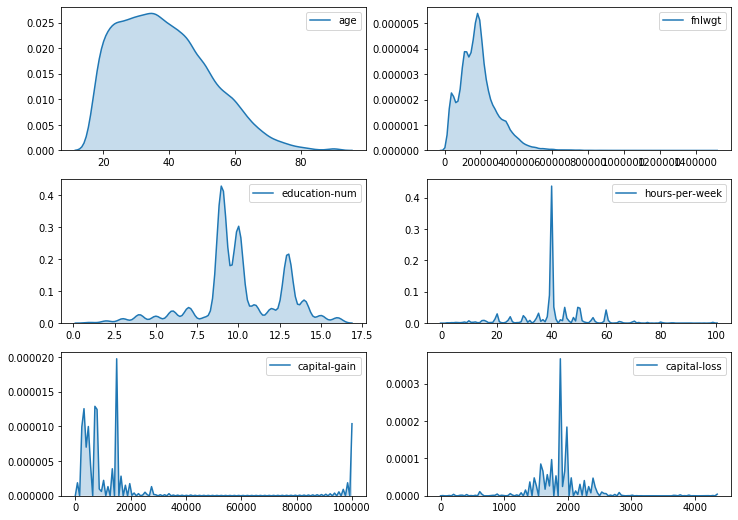

In [13]:
import seaborn as sns
f, axes = plt.subplots(3,2, figsize=(12,9))
sns.kdeplot(train_data['age'], shade=True, ax=axes[0, 0])
sns.kdeplot(train_data['fnlwgt'], shade=True, ax=axes[0, 1])
sns.kdeplot(train_data['education-num'], shade=True, ax=axes[1, 0])
sns.kdeplot(train_data['hours-per-week'], shade=True, ax=axes[1, 1])
sns.kdeplot(train_data['capital-gain'], shade=True, ax=axes[2, 0])
sns.kdeplot(train_data['capital-loss'], shade=True, ax=axes[2, 1])

These features behave normally so I simply divide them each into 3 sections.

In [14]:
pos1 = int(len(train_data)/3)
pos2 = 2 * pos1
intervals = {}

for col in continuous_cols:
    print('Col:', col)
    i1 = sorted(train_data[col])[pos1]
    i2 = sorted(train_data[col])[pos2]
    intervals[col] = (range(0, i1+1), range(i1+1, i2+1), range(i2+1, sorted(train_data[col])[len(train_data)-1]+1))
    print('Sections: [0 %d] [%d %d] [%d %d]' % (i1, i1+1, i2, i2+1, sorted(train_data[col])[len(train_data)-1]+1))

Col: age
Sections: [0 31] [32 44] [45 91]
Col: fnlwgt
Sections: [0 141058] [141059 210474] [210475 1484706]
Col: education-num
Sections: [0 9] [10 10] [11 17]
Col: capital-gain
Sections: [0 0] [1 0] [1 100000]
Col: capital-loss
Sections: [0 0] [1 0] [1 4357]
Col: hours-per-week
Sections: [0 40] [41 40] [41 100]


## 1.4 Text attr. to int

In [15]:
rev_intervals = {}
for k, v in intervals.items():
    tmp = {}
    for idx, r in enumerate(v):
        for i in r:
            tmp[i] = idx
    rev_intervals[k] = tmp

dsp_dict = {
    1: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
    3: ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
    5: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
    6: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
    7: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
    8: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
    9: ['Female', 'Male'],
    13: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']
}

def dsp2numlist(idx):
    return list(range(len(dsp_dict[idx])))

AttrSet = [
    (0, [0,1,2], 'age'),
    (1, dsp2numlist(1), 'workclass'),
    (2, [0,1,2], 'fnlwgt'),
    (3, dsp2numlist(3), 'education'),
    (4, [0,1,2], 'education-num'),
    (5, dsp2numlist(5), 'marital-status'),
    (6, dsp2numlist(6), 'occupation'),
    (7, dsp2numlist(7), 'relationship'),
    (8, dsp2numlist(8), 'race'),
    (9, dsp2numlist(9), 'sex'),
    (10,[0,1,2], 'capital-gain'),
    (11,[0,1,2], 'capital-loss'),
    (12,[0,1,2], 'hours-per-week'),
    (13,dsp2numlist(13),'native-country')
]


In [16]:
train_label = [1 if val == ' >50K' else 0 for val in train_data['Salaries']]
train_input = []

for idx in range(len(train_data)):
    tmp = [dsp_dict[i].index(val.strip()) if int(i) in dsp_dict.keys()
           else rev_intervals[train_data.columns[i]].get(val, 2) for i, val in enumerate(train_data.iloc[idx][:-1])]
    train_input.append(tmp)

test_label = [1 if val == ' >50K.' else 0 for val in test_data['Salaries']]
test_input = []

for idx in range(len(test_data)):
    tmp = [dsp_dict[i].index(val.strip()) if int(i) in dsp_dict.keys()
           else rev_intervals[test_data.columns[i]].get(val, 2) for i, val in enumerate(test_data.iloc[idx][:-1])]
    test_input.append(tmp)

In [17]:
print(len(train_label))
print(len(train_input))
print(train_input[:2])

print(len(test_label))
print(len(test_input))
print(test_input[:2])

32561
32561
[[1, 5, 0, 0, 2, 2, 8, 3, 0, 1, 2, 0, 0, 0], [2, 1, 0, 0, 2, 0, 4, 2, 0, 1, 0, 0, 0, 0]]
16281
16281
[[2, 0, 2, 2, 0, 2, 7, 1, 4, 1, 0, 0, 0, 0], [2, 0, 0, 3, 0, 0, 9, 2, 0, 1, 0, 0, 2, 0]]


---

# 2 Utilities

[TOP](#E11-Decision-Tree)

## 2.1 Entropy

$Ent(D) = -\sum\limits_{k=1}^{|Y|}p_klog_2p_k$

In this case, $|Y| = 2$ for $y_1 = '\geq50K'$ and $y_2 = '<50K'$

**Function: Entropy(Data)**

**parameters:**
- Data: 2-d matrix, Current data set.

**return:**
- Information entropy of current data set.

In [18]:
def Entropy(Data):
    # Labels were stored at tail of the data set.
    labels = [sample[-1] for sample in Data]
    # Use set() to remove duplicates
    types = set(labels)
    # To calculate Pr by Pr = sample_num / total_num
    types_counts = [labels.count(type) for type in types]
    probs = [prob/len(Data) for prob in types_counts]
    # Calculate final result
    return -np.sum(probs*np.log2(probs))

## 2.2 Information Gain

$\operatorname{Gain}(D, a)=\operatorname{Ent}(D)-\sum\limits_{v=1}^{V} \dfrac{\left|D^{v}\right|}{|D|} \operatorname{Ent}\left(D^{v}\right)$

Ent(D) has been defined above.

**Function: Gain(Data, attr)**

**parameters:**
- Data: 2-d matrix, Current data set.
- attr: (attr_num(int), attr_vals(list), attr_name(str)), Current attribute to calculate information gain.

**return:**
- Information gain by splitting the data set with attr.

In [19]:
def Gain(Data, attr):
    # Get Entropy of current data
    entropy = Entropy(Data)
    # Get the position of current attribute
    attr_num = attr[0]
    # Get all possible values for current attribute
    attr_vals = attr[1]
    # Calculate weights and entropy for each branches
    entropys = [0 for val in attr_vals]
    weights = [0 for val in attr_vals]
    # Enumerates attr_vals
    for idx, val in enumerate(attr_vals):
        # for each value, general an subset to
        # help calculate its entropy.
        sub_data = []
        for sample in Data:
            # when the value on attr_num of a sample
            # equals to val, this sample should be
            # a member of set 'D^v'
            if sample[attr_num] == val:
                sub_data.append(sample)
                weights[idx] += 1
        entropys[idx] = Entropy(sub_data)
        weights[idx] /= len(Data)
    # Calculate the final result
    return entropy - np.sum(np.multiply(weights, entropys))

## 2.3 Gini index

$$
\begin{aligned} \operatorname{Gini}(D) &=\sum_{k=1}^{|\mathcal{Y}|} \sum_{k^{\prime} \neq k} p_{k} p_{k^{\prime}} \\ &=1-\sum_{k=1}^{|\mathcal{Y}|} p_{k}^{2} \\
\operatorname{Gini} \operatorname{index}(D, a)&=\sum_{v=1}^{V} \frac{\left|D^{v}\right|}{|D|} \operatorname{Gini}\left(D^{v}\right)
\end{aligned}
$$

For further study, I calculate gini index in order to see the difference between id3 and CART decision Tree.

**Function: Gini(Data)**

**parameters:**
- Data: 2-d matrix, Current data set.

**return:**
- Gini value of current data set.

In [20]:
def Gini(Data):
    # Labels were stored at tail of the data set.
    labels = [sample[-1] for sample in Data]
    # Use set() to remove duplicates
    types = set(labels)
    # To calculate Pr by Pr = sample_num / total_num
    types_counts = [labels.count(type) for type in types]
    probs = [prob/len(Data) for prob in types_counts]
    # Calculate final result
    return 1 - np.sum(np.power(probs, 2))

**Function: Gini_index(Data, attr)**

**parameters:**
- Data: 2-d matrix, Current data set.
- attr: (attr_num(int), attr_vals(list), attr_name(str)), Current attribute to calculate Gini index.

**return:**
- Gini index by splitting the data set with attr.

In [21]:
    def Gini_index(Data, attr):
        # Get Gini value of current data
        gini = Gini(Data)
        # Get the position of current attribute
        attr_num = attr[0]
        # Get all possible values for current attribute
        attr_vals = attr[1]
        # Calculate weights and entropy for each branches
        ginis = [0 for val in attr_vals]
        weights = [0 for val in attr_vals]
        # Enumerates attr_vals
        for idx, val in enumerate(attr_vals):
            # for each value, general an subset to
            # help calculate its entropy.
            sub_data = []
            for sample in Data:
                # when the value on attr_num of a sample
                # equals to val, this sample should be
                # a member of set 'D^v'
                if sample[attr_num] == val:
                    sub_data.append(sample)
                    weights[idx] += 1
            ginis[idx] = Gini(sub_data)
            weights[idx] /= len(Data)
        # Calculate the final result
        return np.sum(np.multiply(weights, ginis))

## 2.4 chooseBestAttr

It's quite an important step, by Information Gain or Gini index, to automatically find best attribute to split the data set by.

**Function: chooseBestAttr(Data, Attrset)**

**parameters:**
- Data: 2-d matrix, Current data set.
- Attrset: list[attr_tuple], Current attributes set.

**return:**
- Chosen best attribute.

In [22]:
def chooseBestAttr(Data, Attrset, method='ID3'):
    # Initialization
    # Mind that for:
    # Gain info.: find arg_max, init to -1
    # Gini index: find arg_min, init to infinity.
    best_attr = Attrset[0]
    best_gain = -1
    best_gini = np.Inf
    # When 'ID3' is assigned or using default method
    if method == 'ID3':
        for attr_tuple in Attrset:
            gain = Gain(Data, attr_tuple)
            best_attr = attr_tuple if gain > best_gain else best_attr
            best_gain = gain       if gain > best_gain else best_gain
        return best_attr
    # When 'CART' is assigned
    elif method == 'CART':
        for attr_tuple in Attrset:
            gini = Gini_index(Data, attr_tuple)
            best_attr = attr_tuple if gini < best_gini else best_attr
            best_gini = gini       if gini < best_gini else best_gini
        return best_attr
    else:
        print('Unknown method!')
        return None

## 2.5 splitData(Data, attr_num, attr_val)

When the best attribute is chosen, it's time to split data.

**Function: splitData(Data, attr_num, attr_val)**

**parameters:**
- Data: 2-d matrix, Current data set.
- attr_num: int, Current attributes number.
- attr_val: int, one value of the chosen attribute.

**return:**
- Splitted sub data set.

In [23]:
def splitData(Data, attr_num, attr_val):
    # Initialization
    sub_data = []
    # Enumerate Data
    for sample in Data:
        # When the value of sample equals to attr_val,
        # add the sample to sub_data
        if sample[attr_num] == attr_val:
            # new sub_data should not contain the chosen attribute
            sub_data.append(sample[:attr_num] + sample[attr_num+1:])
    return sub_data

## 2.6 getMajority(Data)

When we reach a leaf, this function is necessary to vote for the major label.

Note: When there're more than a single major label...

**Function: getMajority(Data)**

**parameters:**
- Data: 2-d matrix, Current data set.

**return:**
- The major label.

In [24]:
def getMajority(Data):
    # Labels were stored at tail of the data set.
    labels = [sample[-1] for sample in Data]
    # Use set() to remove duplicates
    types = list(set(labels))
    # Counts each type.
    types_counts = [labels.count(type) for type in types]
    # Enumerate to find major label
    major = 0
    max_count = 0
    for idx, type_count in enumerate(types_counts):
        major = types[idx] if max_count < type_count else major
        max_count = type_count if max_count < type_count else max_count
    # Return the type which counts most.
    return str(major)

---


# 3 Generate Decision Tree

[TOP](#E11-Decision-Tree)

**Function: GenerateTree(DataÃ¯Â¼Å’ Attrset, method='ID3')**

**parameters:**
- Data: 2-d matrix, Current data set.
- Attrset: list[attr_tuple], Current attributes set.
- method: str, The Method used to build the decision tree.

**return:**
- Root of the Decision Tree.

In [25]:
def GenerateTree(Data, Attrset, method='ID3'):
    # Labels were stored at tail of the data set.
    labels = [sample[-1] for sample in Data]
    
    # ================ Terminals Check ================= 
    # The following IF sentences will
    # determine if the node if a leaf.
    
    # 1# ALL the SAME labels
    if len(set(labels)) == 1:
        # LEAF node | value = any one of the same labels
        return str(labels[0])
    
    # 2# No Attributes left
    if len(Attrset) == 0:
        # LEAF node | value = the major label
        return getMajority(Data)

    # 3# Samples behave the same on Attrset
    flag = False
    for attr_tuple in Attrset:
        if len(set([sample[attr_tuple[0]] for sample in Data])) != 1:
            flag = True
            break
    if not flag:
        return getMajority(Data)
    
    # ============== Terminals Check Ends ===============
    
    # Choose the best attribute to split the data set by
    best_attr = chooseBestAttr(Data, Attrset, method)
    attr_num = best_attr[0]
    attr_vals = best_attr[1]
    attr_name = best_attr[2]
    for idx, attr in enumerate(Attrset):
        if attr[0] > attr_num:
            Attrset[idx] = (attr[0]-1, attr[1], attr[2])
    del(Attrset[Attrset.index(best_attr)])
    # Initialzation
    # Current Node is named with attr_num;
    # The empty dict., as its child,
    # will be fill in following steps.
    Node = {attr_name: {}}
    
    # Enumerate values of the best attributes
    for val in attr_vals:
        sub_data = splitData(Data, attr_num, val)
        if len(sub_data) == 0:
            return getMajority(Data)
        else:
            Node[attr_name][val] = GenerateTree(sub_data, Attrset[:], method)
            
    # Return the Node as the result
    return Node

---

# 4 Classifier 

[TOP](#E11-Decision-Tree)

Use the Tree Generator above to create a classifier.

## 4.1 Classifier(DecisionTree, AttrSet, SampleData)

**Function: Classifier(DecisionTree, AttrSet, SampleData)**

**parameters:**
- DecisionTree: Dict, a decision tree.
- AttrSet: list[attr_tuple], Attributes set for Data.
- SampleData: SampleData to classify.

**return:**
- Classification Result.

In [26]:
def Classifier(DecisionTree, AttrSet, SampleData):
    root = list(DecisionTree.keys())[0]
    for attr_tuple in AttrSet:
        if root == attr_tuple[2]:
            key = SampleData[attr_tuple[0]]
    succ = DecisionTree[root][key]
    if isinstance(succ, dict):
        return Classifier(succ, AttrSet, SampleData)
    else:
        return succ

## 4.2 Benchmarker(DecisionTree,  AttrSet, testing_data, log)

**Function: Benchmarker(DecisionTree, AttrSet, testing_data, log=False)**

**parameters:**
- DecisionTree: Dict, a decision tree.
- AttrSet: list[attr_tuple], Attributes set for Data.
- testing_data: 2-d matrix, testing data to evaluate the model.
- log: boolean, true to print out the process.

**return:**
- Accuracy on the testing_data.

In [27]:
def Benchmarker(DecisionTree, AttrSet, testing_data, log=False):
    labels = [sample[-1] for sample in testing_data]
    res = []
    for sample in testing_data:
        res.append(Classifier(DecisionTree, AttrSet, sample[:-1]))
    check = [labels[idx] + int(res[idx]) for idx in range(len(testing_data))]
    if log:
        for idx in range(len(testing_data)):
            if idx % 1000 == 0:
                print(" T ", end='') if labels[idx] == int(res[idx]) else print(" F ", end='')
                print('%5d: expected %d, classified to %d.' % (idx, labels[idx], int(res[idx])))
        print("Total Accuracy: %.5f" % (1-check.count(1)/len(testing_data)))
    else:
        return 1 - check.count(1)/len(testing_data)

## 4.3 Benchmarking and plotting


********** Testing with ID3 **********
 F     0: expected 1, classified to 0.
Total Accuracy: 0.64706

********** Testing with CART **********
 F     0: expected 1, classified to 0.
Total Accuracy: 0.64706


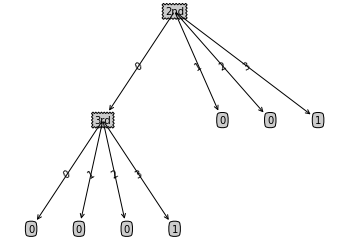

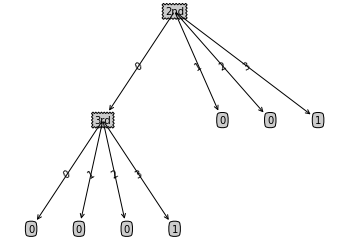

In [38]:
from src import treePlotter as tp
testing_data = [
    [0,1,1,1],
    [1,3,5,1],
    [3,3,3,1],
    [3,2,2,1],
    [2,1,6,1],
    [0,3,3,1],
    [1,2,4,1],
    [1,2,2,1],
    
    [0,1,6,0],
    [1,3,4,0],
    [1,3,3,0],
    [0,2,3,0],
    [2,2,2,0],
    [0,0,1,0],
    [1,2,3,0],
    [1,1,0,0],
    [1,0,0,1]
]

testing_attrset = [(0, [0,1,2,3],'2nd'), (1, [0,1,2,3],'3rd'), (2, [0,1,2,3,4,5,6], '4th')]

print('\n'+"*"*10+' Testing with ID3 '+"*"*10)
dt = GenerateTree(testing_data, testing_attrset[:])
tp.createPlot(dt)
Benchmarker(dt, testing_attrset, testing_data, True)

print('\n'+"*"*10+' Testing with CART '+"*"*10)
dt = GenerateTree(testing_data, testing_attrset[:], 'CART')
tp.createPlot(dt)
Benchmarker(dt, testing_attrset, testing_data, True)

---


# 5 Feed with 'Salary Data' and Model Storage 

[TOP](#E11-Decision-Tree)

After benchmarking and debugging, I will feed the decision tree with the data generated in Section 1.

And for reusage, store it.

## Review On the data

In [39]:
# training data
print("Training Inputs:", train_input[:2])
print("Training Labels:", train_label[:2])
# combined
X_train = [data + [train_label[idx]] for idx, data in enumerate(train_input)]
print("Combined Training data:", X_train[:2], '\n')

# testing data
print("Testing Inputs:", test_input[:2])
print("Testing Labels:", test_label[:2])
# combined
X_test = [data + [test_label[idx]] for idx, data in enumerate(test_input)]
print("Combined Testing data:", X_test[:2], '\n')

# Attribute Set
print("Attribute Set:[index, domain, name]")
display(AttrSet[:5])

Training Inputs: [[1, 5, 0, 0, 2, 2, 8, 3, 0, 1, 2, 0, 0, 0], [2, 1, 0, 0, 2, 0, 4, 2, 0, 1, 0, 0, 0, 0]]
Training Labels: [0, 0]
Combined Training data: [[1, 5, 0, 0, 2, 2, 8, 3, 0, 1, 2, 0, 0, 0, 0], [2, 1, 0, 0, 2, 0, 4, 2, 0, 1, 0, 0, 0, 0, 0]] 

Testing Inputs: [[2, 0, 2, 2, 0, 2, 7, 1, 4, 1, 0, 0, 0, 0], [2, 0, 0, 3, 0, 0, 9, 2, 0, 1, 0, 0, 2, 0]]
Testing Labels: [0, 0]
Combined Testing data: [[2, 0, 2, 2, 0, 2, 7, 1, 4, 1, 0, 0, 0, 0, 0], [2, 0, 0, 3, 0, 0, 9, 2, 0, 1, 0, 0, 2, 0, 0]] 

Attribute Set:[index, domain, name]


[(0, [0, 1, 2], 'age'),
 (1, [0, 1, 2, 3, 4, 5, 6, 7], 'workclass'),
 (2, [0, 1, 2], 'fnlwgt'),
 (3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'education'),
 (4, [0, 1, 2], 'education-num')]

## 5.1 Training on ID3 (Argmax on Gain_info)


********** Salary Data with ID3 **********
 T     0: expected 0, classified to 0.
 T  1000: expected 0, classified to 0.
 T  2000: expected 0, classified to 0.
 T  3000: expected 0, classified to 0.
 F  4000: expected 0, classified to 1.
 T  5000: expected 1, classified to 1.
 T  6000: expected 0, classified to 0.
 T  7000: expected 1, classified to 1.
 T  8000: expected 1, classified to 1.
 T  9000: expected 0, classified to 0.
 T 10000: expected 0, classified to 0.
 T 11000: expected 0, classified to 0.
 T 12000: expected 0, classified to 0.
 F 13000: expected 0, classified to 1.
 F 14000: expected 1, classified to 0.
 T 15000: expected 0, classified to 0.
 F 16000: expected 1, classified to 0.
 T 17000: expected 1, classified to 1.
 T 18000: expected 0, classified to 0.
 T 19000: expected 0, classified to 0.
 T 20000: expected 0, classified to 0.
 T 21000: expected 0, classified to 0.
 T 22000: expected 1, classified to 1.
 T 23000: expected 0, classified to 0.
 T 24000: expected 0

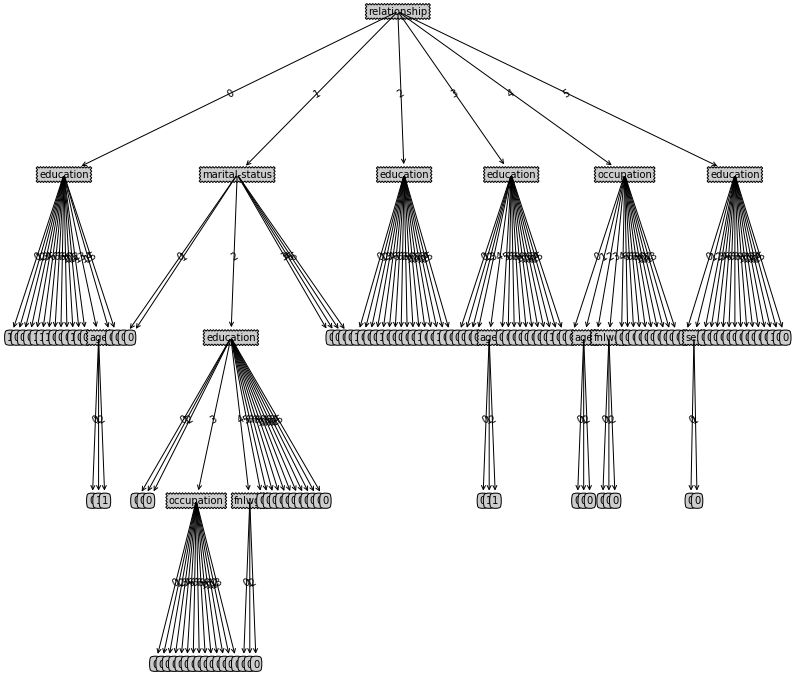

In [40]:
print('\n'+"*"*10+' Salary Data with ID3 '+"*"*10)
SalaryPredict_DT_ID3 = GenerateTree(X_train, AttrSet[:])
plt.subplots(figsize=(14,12))
tp.createPlot(SalaryPredict_DT_ID3)
Benchmarker(SalaryPredict_DT_ID3, AttrSet, X_train, True)

## 5.2 Training on CART (Argmin on Gini_index)


********** Salary Data with CART **********
 T     0: expected 0, classified to 0.
 T  1000: expected 0, classified to 0.
 T  2000: expected 0, classified to 0.
 T  3000: expected 0, classified to 0.
 F  4000: expected 0, classified to 1.
 T  5000: expected 1, classified to 1.
 T  6000: expected 0, classified to 0.
 T  7000: expected 1, classified to 1.
 T  8000: expected 1, classified to 1.
 T  9000: expected 0, classified to 0.
 T 10000: expected 0, classified to 0.
 T 11000: expected 0, classified to 0.
 T 12000: expected 0, classified to 0.
 F 13000: expected 0, classified to 1.
 F 14000: expected 1, classified to 0.
 T 15000: expected 0, classified to 0.
 F 16000: expected 1, classified to 0.
 T 17000: expected 1, classified to 1.
 T 18000: expected 0, classified to 0.
 T 19000: expected 0, classified to 0.
 T 20000: expected 0, classified to 0.
 T 21000: expected 0, classified to 0.
 T 22000: expected 1, classified to 1.
 T 23000: expected 0, classified to 0.
 T 24000: expected 

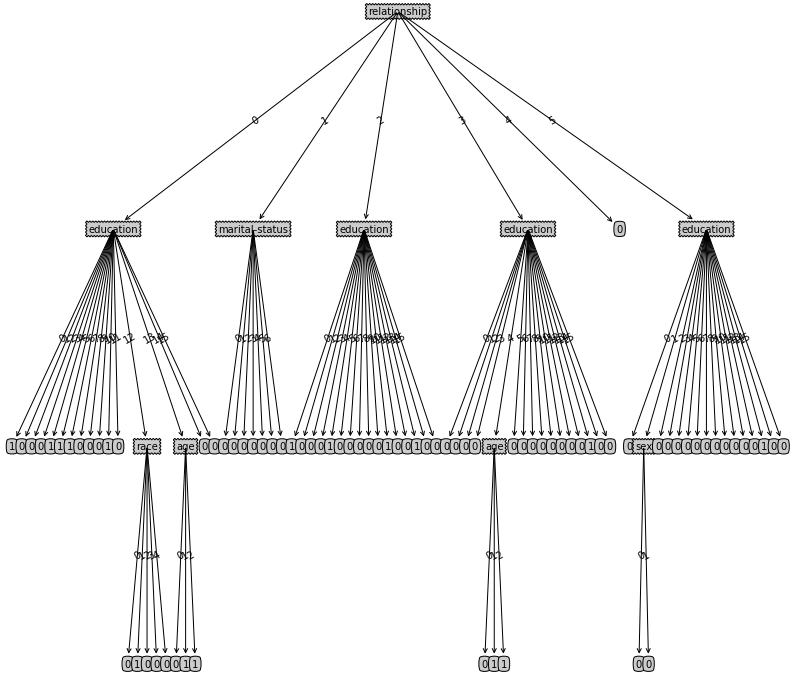

In [41]:
print('\n'+"*"*10+' Salary Data with CART '+"*"*10)
SalaryPredict_DT_CART = GenerateTree(X_train, AttrSet[:], 'CART')
plt.subplots(figsize=(14,12))
tp.createPlot(SalaryPredict_DT_CART)
Benchmarker(SalaryPredict_DT_CART, AttrSet, X_train, True)

In this case, ID3 doesn't distinguish from CART much,

the only difference between there Accuracy on Training set is:

$0.82181(CART) - 0.82178(ID3) < 0.001$

## 5.3 Behavior on testing set

I have no confidence on the model actually...

In [42]:
print('\n'+"*"*10+' Testing Salary Data with ID3 '+"*"*10)
Benchmarker(SalaryPredict_DT_ID3, AttrSet, X_test, True)


********** Testing Salary Data with ID3 **********
 T     0: expected 0, classified to 0.
 T  1000: expected 0, classified to 0.
 T  2000: expected 0, classified to 0.
 T  3000: expected 0, classified to 0.
 T  4000: expected 0, classified to 0.
 T  5000: expected 1, classified to 1.
 T  6000: expected 0, classified to 0.
 T  7000: expected 0, classified to 0.
 T  8000: expected 0, classified to 0.
 T  9000: expected 0, classified to 0.
 F 10000: expected 1, classified to 0.
 F 11000: expected 0, classified to 1.
 F 12000: expected 1, classified to 0.
 T 13000: expected 1, classified to 1.
 F 14000: expected 1, classified to 0.
 F 15000: expected 1, classified to 0.
 F 16000: expected 1, classified to 0.
Total Accuracy: 0.82212


In [43]:
print('\n'+"*"*10+' Testing Salary Data with CART '+"*"*10)
Benchmarker(SalaryPredict_DT_CART, AttrSet, X_test, True)


********** Testing Salary Data with CART **********
 T     0: expected 0, classified to 0.
 T  1000: expected 0, classified to 0.
 T  2000: expected 0, classified to 0.
 T  3000: expected 0, classified to 0.
 T  4000: expected 0, classified to 0.
 T  5000: expected 1, classified to 1.
 T  6000: expected 0, classified to 0.
 T  7000: expected 0, classified to 0.
 T  8000: expected 0, classified to 0.
 T  9000: expected 0, classified to 0.
 F 10000: expected 1, classified to 0.
 F 11000: expected 0, classified to 1.
 F 12000: expected 1, classified to 0.
 T 13000: expected 1, classified to 1.
 F 14000: expected 1, classified to 0.
 F 15000: expected 1, classified to 0.
 F 16000: expected 1, classified to 0.
Total Accuracy: 0.82212


As you can see, ID3 and CART behave the same and reach an Accuracy of 82%.

It's Okay for me XD.

## 5.4 Save the Decision Tree

For Your convinience, I serialize the model into two files:

`'SalaryPredict_DT_ID3.pkl'` and `'SalaryPredict_DT_CART.pkl'`

In [44]:
import pickle as pk
with open('./DTmodel/SalaryPredict_DT_ID3.pkl', 'wb') as pkl:
    pk.dump(SalaryPredict_DT_ID3, pkl)

with open('./DTmodel/SalaryPredict_DT_CART.pkl', 'wb') as pkl:
    pk.dump(SalaryPredict_DT_CART, pkl)

Please Load it with python module `pickle` as follow:

In [47]:
import pickle as pk
with open('./DTmodel/SalaryPredict_DT_ID3.pkl', 'rb') as pkl:
    SalaryPredict_DT_ID3 = pk.load(pkl)

with open('./DTmodel/SalaryPredict_DT_CART.pkl', 'rb') as pkl:
    SalaryPredict_DT_CART = pk.load(pkl)

print('\n'+"*"*10+' Testing Salary Data with ID3 '+"*"*10)
Benchmarker(SalaryPredict_DT_ID3, AttrSet, X_test, True)


********** Testing Salary Data with ID3 **********
 T     0: expected 0, classified to 0.
 T  1000: expected 0, classified to 0.
 T  2000: expected 0, classified to 0.
 T  3000: expected 0, classified to 0.
 T  4000: expected 0, classified to 0.
 T  5000: expected 1, classified to 1.
 T  6000: expected 0, classified to 0.
 T  7000: expected 0, classified to 0.
 T  8000: expected 0, classified to 0.
 T  9000: expected 0, classified to 0.
 F 10000: expected 1, classified to 0.
 F 11000: expected 0, classified to 1.
 F 12000: expected 1, classified to 0.
 T 13000: expected 1, classified to 1.
 F 14000: expected 1, classified to 0.
 F 15000: expected 1, classified to 0.
 F 16000: expected 1, classified to 0.
Total Accuracy: 0.82212


Great, it works.

[TOP](#E11-Decision-Tree)

---

2019/11 Karl